# **Imports**

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
from sklearn.model_selection import GridSearchCV
from scipy import stats

# **Dataset loading**

In [58]:
# Step 1: Load and Explore the Dataset

iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Create a DataFrame for easier exploration
iris_df = pd.DataFrame(X, columns=feature_names)
iris_df['species'] = [target_names[i] for i in y]

# Print the first few rows
print("\nFirst 5 rows of the dataset:")
print(iris_df.head())

# Check basic statistics
print("\nBasic statistics:")
print(iris_df.describe())

# Check for missing values
print("\nMissing values check:")
print(iris_df.isnull().sum())


First 5 rows of the dataset:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  

Basic statistics:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%           

In [61]:
count=iris_df["species"].value_counts()
print(count)

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


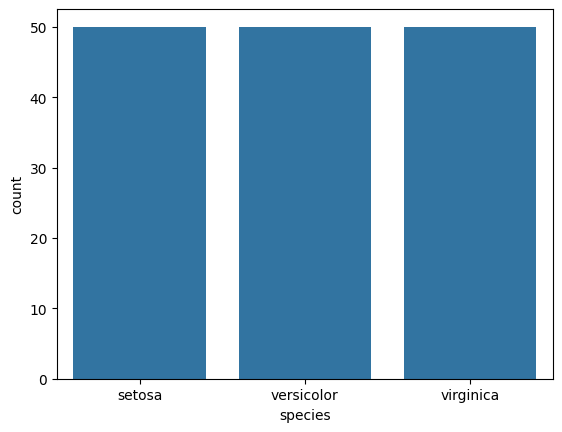

In [62]:
sns.countplot(x="species",data=iris_df)
plt.show()

# **Checking for Duplicates**

In [ ]:
# Check for duplicate rows
print("\nChecking for duplicate rows:")
duplicates = iris_df.duplicated()
duplicate_count = duplicates.sum()
print(f"Number of duplicate rows: {duplicate_count}")

if duplicate_count > 0:
    # Remove duplicates and keep first occurrence
    iris_df = iris_df.drop_duplicates()
    print(f"Dataset shape after removing duplicates: {iris_df.shape}")
    
    # Update X and y after removing duplicates
    X = iris_df.iloc[:, :-1].values
    y = np.array([list(target_names).index(species) for species in iris_df['species']])
else:
    print("No duplicates found in the dataset.")


Checking for duplicate rows:
Number of duplicate rows: 1
Dataset shape after removing duplicates: (149, 5)


# **Visualizing**

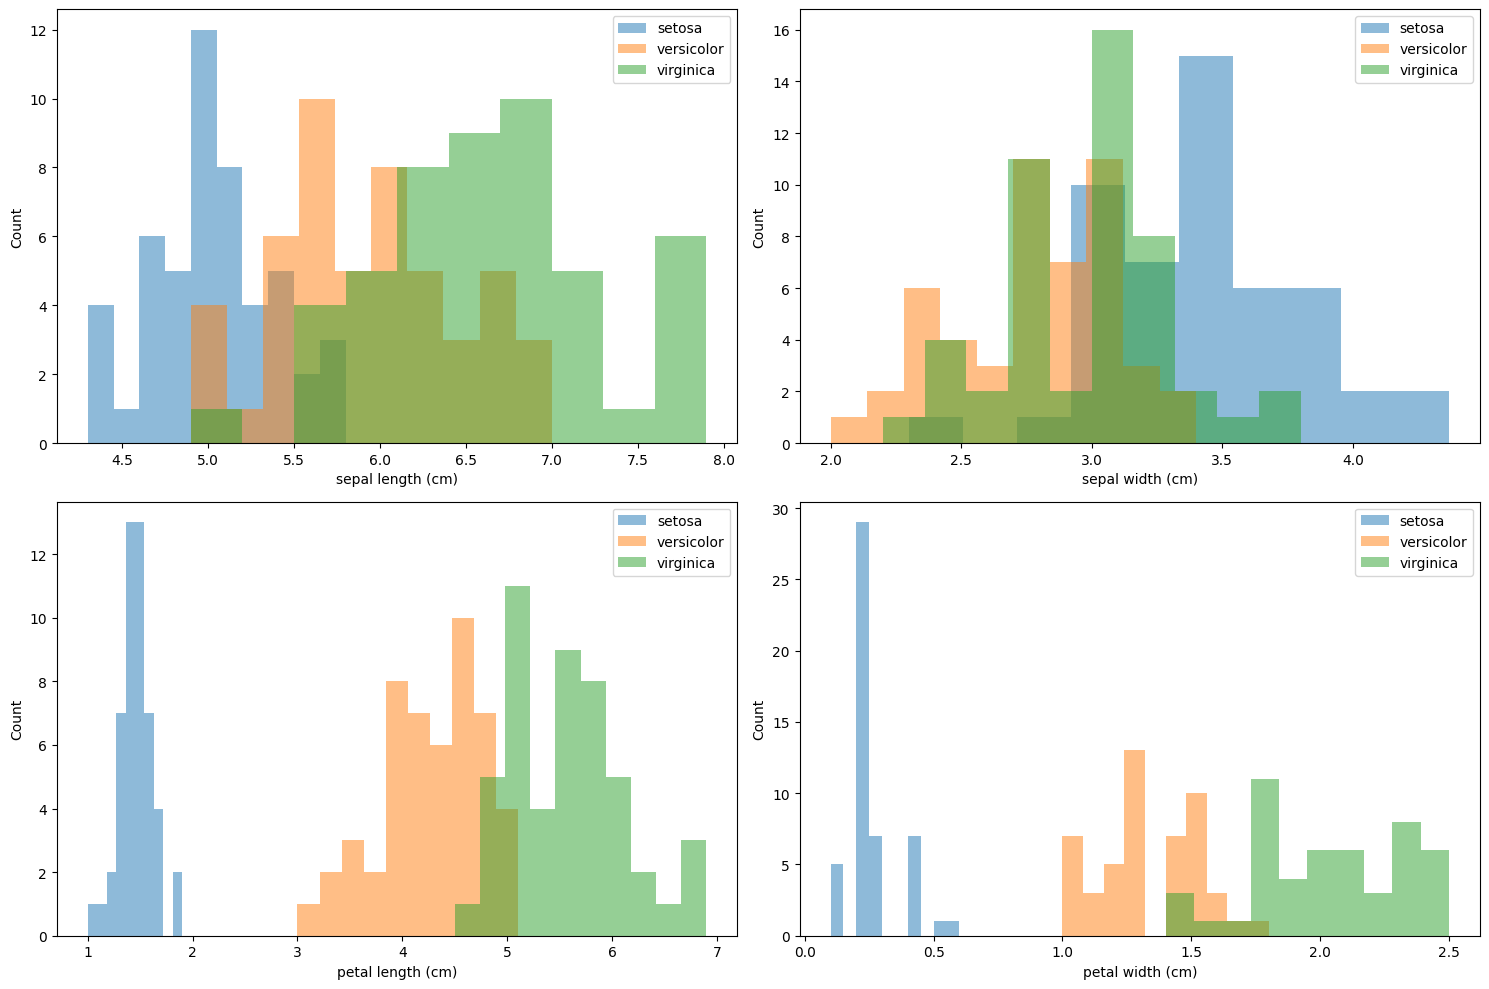

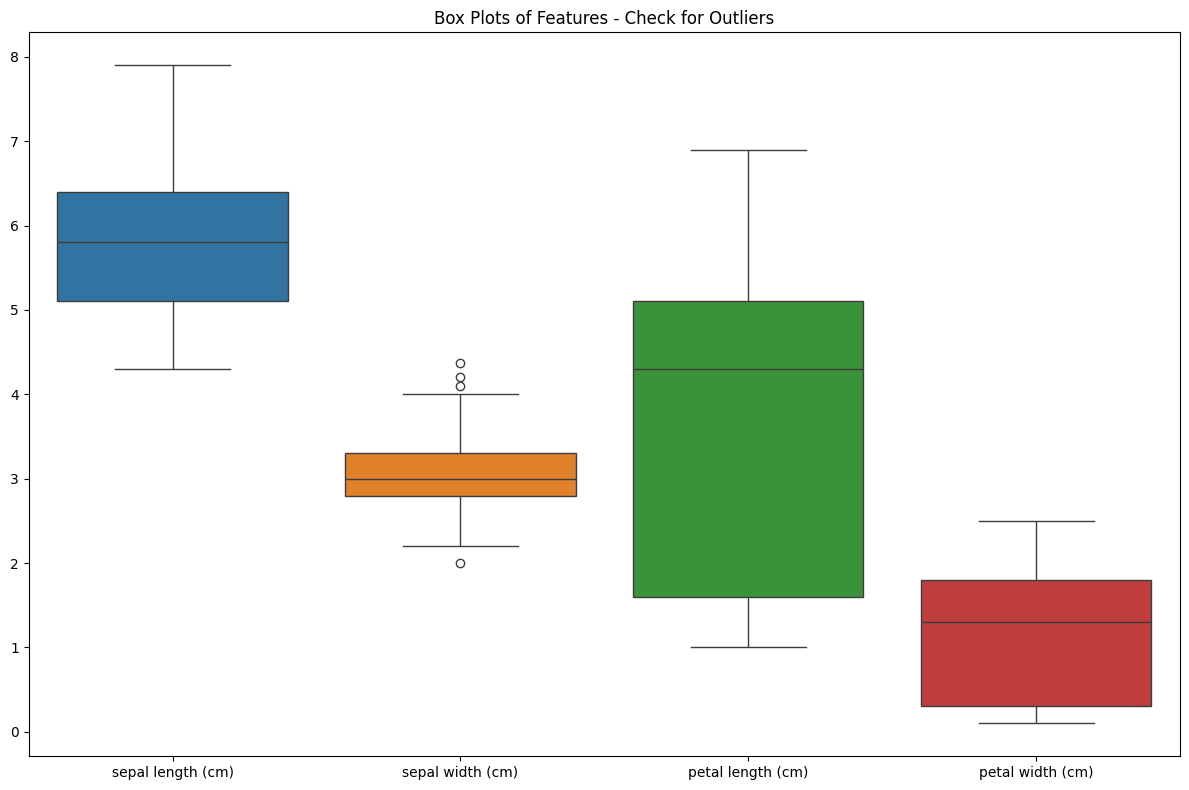

In [56]:
#Data Preprocessing and Exploration
#Visualize the data distribution
plt.figure(figsize=(15, 10))
for i, feature in enumerate(feature_names):
    plt.subplot(2, 2, i+1)
    for species in range(3):
        plt.hist(X[y == species, i], bins=10, alpha=0.5, label=target_names[species])
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend()
plt.tight_layout()

#Box plots to identify outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=iris_df.iloc[:, :-1])
plt.title('Box Plots of Features - Check for Outliers')
plt.tight_layout()


# **Outlier detection and correlation analysis**

Number of outliers detected: 1
Outlier indices: [15]
Outlier values:
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
15                5.7               4.4                1.5               0.4   

   species  
15  setosa  


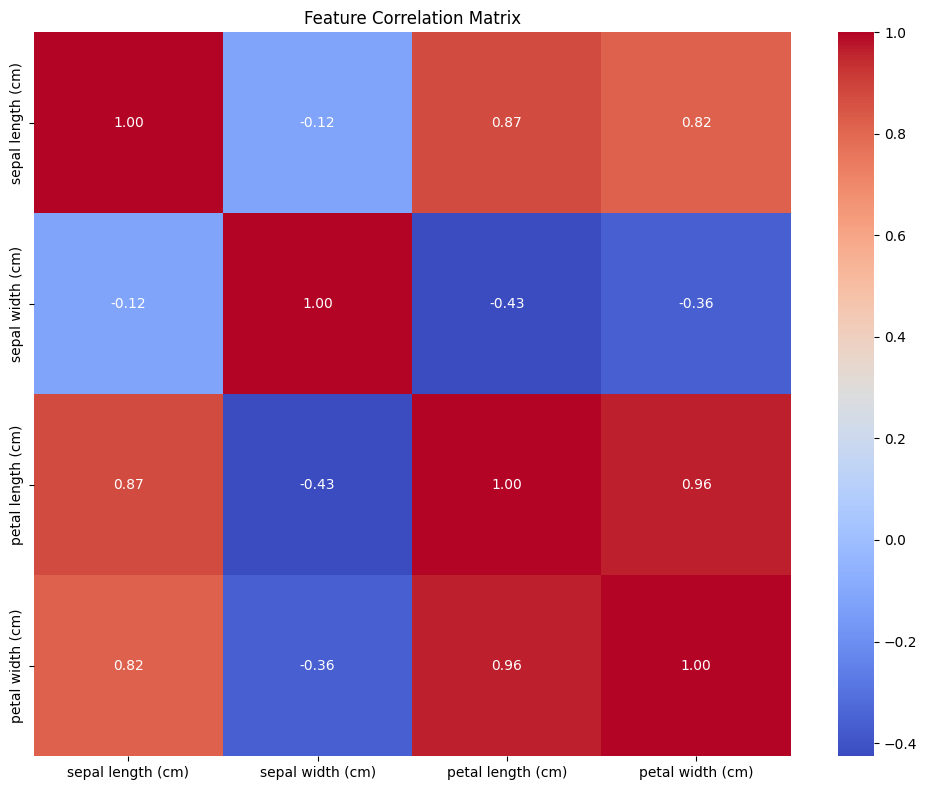

In [ ]:
# Outlier Detection using Z-score

z_scores = stats.zscore(iris_df.iloc[:, :-1])
abs_z_scores = np.abs(z_scores)
outlier_indices = np.where(abs_z_scores > 3)[0]
print(f"Number of outliers detected: {len(np.unique(outlier_indices))}")
if len(outlier_indices) > 0:
    print("Outlier indices:", np.unique(outlier_indices))
    print("Outlier values:")
    print(iris_df.iloc[np.unique(outlier_indices)])

# Correlation Analysis
plt.figure(figsize=(10, 8))
correlation_matrix = iris_df.iloc[:, :-1].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()


# **Outlier handling**

In [47]:

if len(np.unique(outlier_indices)) > 0:
    print(f"Found {len(np.unique(outlier_indices))} rows with outliers")
    iris_df_capped = iris_df.copy()
    
    for column in iris_df.iloc[:, :-1].columns:
        mean = iris_df[column].mean()
        std = iris_df[column].std()
        
        # Cap upper outliers
        upper_limit = mean + 3 * std
        iris_df_capped.loc[iris_df_capped[column] > upper_limit, column] = upper_limit
        
        # Cap lower outliers
        lower_limit = mean - 3 * std
        iris_df_capped.loc[iris_df_capped[column] < lower_limit, column] = lower_limit
    
    print("Summary of capped dataset:")
    print(iris_df_capped.describe())
    
    
    iris_df = iris_df_capped
    X = iris_df.iloc[:, :-1].values
    y = np.array([list(target_names).index(species) for species in iris_df['species']])
else:
    print("No outliers found using the Z-score method (threshold = 3).")

Found 1 rows with outliers
Summary of capped dataset:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         149.000000        149.000000         149.000000   
mean            5.843624          3.059522           3.748993   
std             0.830851          0.435701           1.767791   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.300000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.368758           6.900000   

       petal width (cm)  
count        149.000000  
mean           1.194631  
std            0.762622  
min            0.100000  
25%            0.300000  
50%            1.300000  
75%            1.800000  
max            2.500000  


# **Applying PCA**

In [48]:
# Find highly correlated features (>0.95 )
high_corr_pairs = []
high_corr_features = set()

for i in range(len(feature_names)):
    for j in range(i+1, len(feature_names)):
        if abs(correlation_matrix.iloc[i, j]) > 0.95: 
            print(f"High correlation between {feature_names[i]} and {feature_names[j]}: {correlation_matrix.iloc[i, j]:.4f}")
            high_corr_pairs.append((feature_names[i], feature_names[j]))
            high_corr_features.add(i)
            high_corr_features.add(j)

high_corr_features = list(high_corr_features)
high_corr_feature_names = [feature_names[i] for i in high_corr_features]


print(high_corr_feature_names)

if not high_corr_features:
    max_corr = 0
    max_pair = (0, 0)
    for i in range(len(feature_names)):
        for j in range(i+1, len(feature_names)):
            if abs(correlation_matrix.iloc[i, j]) > max_corr:
                max_corr = abs(correlation_matrix.iloc[i, j])
                max_pair = (i, j)
    
    print(f"\nNo features with correlation > 0.95 found.")
    print(f"Highest correlation is between {feature_names[max_pair[0]]} and {feature_names[max_pair[1]]}: {max_corr:.4f}")
    print(f"Using these two features for PCA demonstration.")
    
    high_corr_features = [max_pair[0], max_pair[1]]
    high_corr_feature_names = [feature_names[i] for i in high_corr_features]

High correlation between petal length (cm) and petal width (cm): 0.9628
['petal length (cm)', 'petal width (cm)']


# **PCA**


PCA for highly correlated features:
Explained variance ratios: [0.98138615 0.01861385]
Cumulative explained variance: [0.98138615 1.        ]
Optimal number of PCA components (95% variance): 1
PCA explained variance plot saved as 'pca_explained_variance.png'


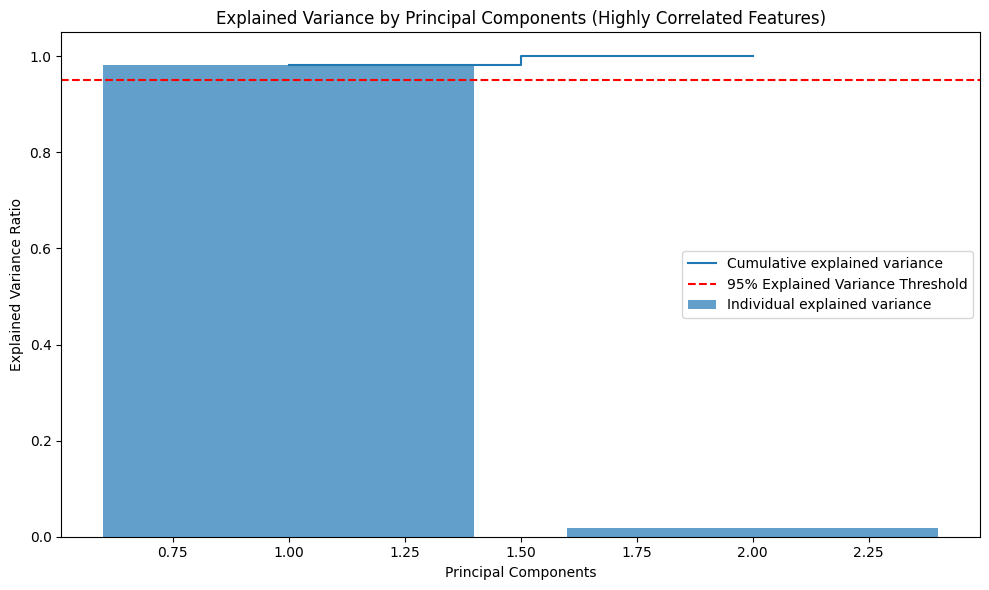

In [ ]:
#Apply PCA only to highly correlated features
X_for_pca = X[:, high_corr_features]
feature_names_for_pca = high_corr_feature_names

# Standardize and apply PCA to selected features
scaler = StandardScaler()
X_scaled_for_pca = scaler.fit_transform(X_for_pca)

pca = PCA()
X_pca = pca.fit_transform(X_scaled_for_pca)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print("\nPCA for highly correlated features:")
print(f"Explained variance ratios: {explained_variance}")
print(f"Cumulative explained variance: {cumulative_variance}")

# Determine optimal number of components (95% variance explained)
if len(high_corr_features) > 1:  
    optimal_n_components = np.argmax(cumulative_variance >= 0.95) + 1
    print(f"Optimal number of PCA components (95% variance): {optimal_n_components}")
else:
    optimal_n_components = 1
    print(f"Only one feature selected, using 1 component for PCA")

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components (Highly Correlated Features)')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance Threshold')
plt.legend()
plt.tight_layout()


# **shape**

In [50]:
# 2.7: Prepare data for modeling
# Create indices for column transformer
high_corr_indices = high_corr_features
other_indices = [i for i in range(X.shape[1]) if i not in high_corr_indices]

# Split the data into training and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 119 samples
Test set size: 30 samples


# **Model building**


Step 3: Building ML Pipeline with Hyperparameter Tuning
Performing grid search for model with selective PCA...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Best parameters:
{'classifier__bootstrap': True, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best cross-validation accuracy: 0.9496

Optimized model accuracy: 1.0000
Optimized model confusion matrix saved as 'confusion_matrix_optimized.png'

Feature Importance Analysis:
Could not extract feature importances from the pipeline due to PCA transformation.
For models with PCA transformations, original feature importance mapping is not straightforward.


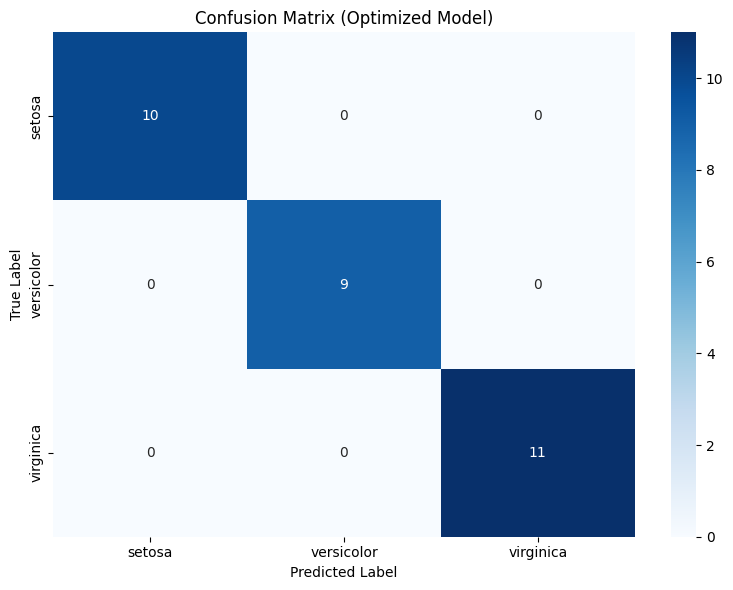

In [ ]:
#Build Machine Learning Pipeline with Selective PCA and Hyperparameter Tuning
print("\nStep 3: Building ML Pipeline with Hyperparameter Tuning")

# Define a transformer that applies PCA only to highly correlated features
if high_corr_features:
    # Create a column transformer that applies PCA only to selected features
    column_transformer = ColumnTransformer(
        transformers=[
            ('pca', Pipeline([
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=min(optimal_n_components, len(high_corr_features))))
            ]), high_corr_indices),
            ('standard', StandardScaler(), other_indices)
        ],
        remainder='passthrough'
    )
    
    # Create the full pipeline
    pipeline = Pipeline([
        ('preprocessor', column_transformer),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
else:
    # If no highly correlated features, just use standard scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=42))
    ])

# The parameter grid to search
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

# Create Grid Search object for the pipeline with PCA
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Use all available processors
    verbose=1
)

# Fit the grid search
print("Performing grid search for model with selective PCA...")
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("\nBest parameters:")
print(grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Get the optimized model
optimized_model = grid_search.best_estimator_

# Test the optimized model
y_pred = optimized_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nOptimized model accuracy: {accuracy:.4f}")

# Visualize the optimized model's confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
          xticklabels=target_names,
          yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Optimized Model)')
plt.tight_layout()
plt.savefig('confusion_matrix_optimized.png')
print("Optimized model confusion matrix saved as 'confusion_matrix_optimized.png'")

# Get feature importance from the optimized model
print("\nFeature Importance Analysis:")

try:
    rf_model = optimized_model.named_steps['classifier']
    # For pipelines with column transformer, accessing feature importance requires mapping
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("Feature Importances:")
    print(feature_importance)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title('Feature Importance in Optimized Random Forest Model')
    plt.tight_layout()
    plt.savefig('feature_importance_optimized.png')
    print("Feature importance plot saved as 'feature_importance_optimized.png'")
except:
    print("Could not extract feature importances from the pipeline due to PCA transformation.")
    # For models with PCA, original feature importance is not directly available
    print("For models with PCA transformations, original feature importance mapping is not straightforward.")

# **Results**


Step 4: Visualizing Results with Confusion Matrix
Confusion matrix saved as 'confusion_matrix_selective_pca.png'


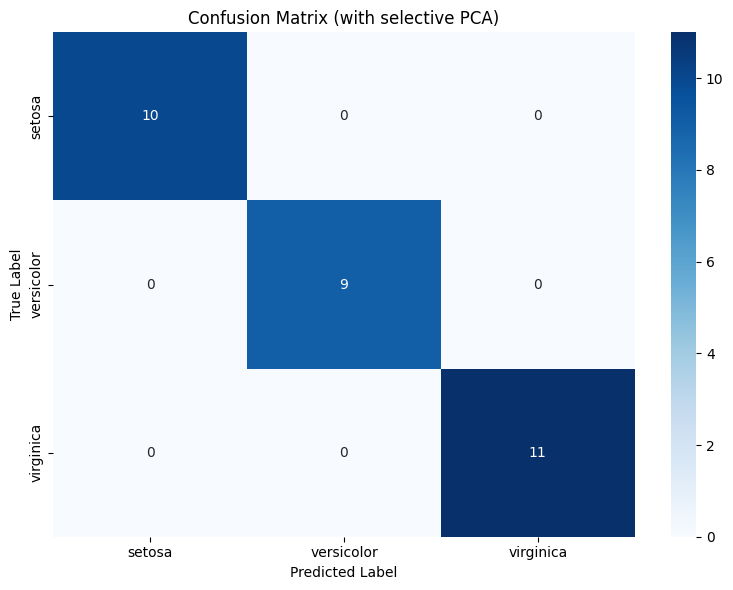

In [ ]:
# Step 4: Visualize the Results
print("\nStep 4: Visualizing Results with Confusion Matrix")
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, 
            yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (with selective PCA)')
plt.tight_layout()

# **Saving the Model**

In [55]:
# Step 6: Save the final model
print("\nStep 6: Saving the Optimized Model")

# Save the final pipeline
model_name = 'iris_classification_with_selective_pca_optimized.joblib'
joblib.dump(optimized_model, model_name)  # Save the fitted model instead
print(f"Final optimized model saved as '{model_name}'")

# Demonstrate loading the model and making a prediction
print("\nLoading the saved model and making a prediction:")
loaded_model = joblib.load(model_name)

# Make a prediction with the loaded model
sample = X_test[0].reshape(1, -1)
prediction = loaded_model.predict(sample)
print(f"Sample features: {sample[0]}")
print(f"Predicted species: {target_names[prediction[0]]}")

# Final cross-validation for the optimized model
print("\nPerforming 5-fold Cross-Validation on the final optimized model:")
cv_scores = cross_val_score(pipeline, X, y, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.4f}")
print(f"Standard deviation: {cv_scores.std():.4f}")


Step 6: Saving the Optimized Model
Final optimized model saved as 'iris_classification_with_selective_pca_optimized.joblib'

Loading the saved model and making a prediction:
Sample features: [6.1 2.8 4.7 1.2]
Predicted species: versicolor

Performing 5-fold Cross-Validation on the final optimized model:
Cross-validation scores: [0.96666667 0.96666667 0.93333333 0.9        1.        ]
Mean CV accuracy: 0.9533
Standard deviation: 0.0340
